
下面简单介绍一下Node2Vec模型：

Node2Vec是一个基于随机游走的图嵌入算法。对于每一个点来说，根据一定的规则，在图上进行随机游走，然后得到一连串的节点信息。将这些节点信息输入到Word2Vec中，得到最后的特征向量。

Node2Vec算法相较于普通的随机游走图嵌入方法，有一个重要的区别是Node2Vec有两个重要的超参数p和q，分别表示```return parameter```和```in-out parameter```

从搜索的角度来说，p和q控制着随机游走更加倾向于dfs还是bfs

从效果的角度来讲，如果p小，q大，则更加倾向于图上结构性的特征；如果p大，q小，则更加倾向于同质性的特征，论文中也提到了这一点。

本次项目更加倾向于同质性的信息，所以根据论文的提示，我们在这里选择p=1，q=0.5作为Node2Vec的超参数

通过上一部分生成的图的信息建图，通过Node2Vec算法进行图嵌入，得到嵌入后的向量

In [235]:
from ge.models import Node2Vec
import networkx as nx

G=nx.read_edgelist("./graph.txt",
                   create_using=nx.DiGraph(),
                   nodetype=None,
                   data=[('weight',int)])
model=Node2Vec(G,walk_length=10,num_walks=100,
               p=1,q=0.5,workers=10,use_rejection_sampling=1)
model.train(window_size=10,iter=20,workers=16,embed_size=256)
embeddings=model.get_embeddings()

Preprocess transition probs...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.7s remaining:    7.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.9s finished


Learning embedding vectors...
Learning embedding vectors done!


通过pickle保存得到的嵌入向量，传递给后面部分使用

In [236]:
import numpy as np
print(np.array(list(embeddings.values())).shape)
# nx.draw_networkx(G,arrowsize=5,node_size=10,with_labels=False,pos=nx.circular_layout(G))
import pickle
pickle.dump(embeddings,open('./embeddings.pkl','wb'))
pickle.dump(G,open('./graph.pkl','wb'))

(661, 256)


建立user和index的映射关系

In [237]:
import os
import csv
data_path='./data/'
lim=10000
user_ind={}
user=[]
with open(os.path.join(data_path,f'followers_over_{lim}.csv'),mode='r',encoding='utf-8') as f:
    user=list(map(lambda x:x[0],csv.reader(f)))
    for i,name in enumerate(user):
        user_ind[name]=i
    csv_reader=csv.reader(f)
print(user_ind)
print(user)

{'torvalds': 0, 'yyx990803': 1, 'gaearon': 2, 'ruanyf': 3, 'gustavoguanabara': 4, 'peng-zhihui': 5, 'openai': 6, 'bradtraversy': 7, 'JakeWharton': 8, 'sindresorhus': 9, 'karpathy': 10, 'microsoft': 11, 'tj': 12, 'rafaballerini': 13, 'getify': 14, 'addyosmani': 15, 'geohot': 16, 'llSourcell': 17, 'michaelliao': 18, 'google': 19, 'wesbos': 20, 'github': 21, 'kentcdodds': 22, 'paulirish': 23, 'filipedeschamps': 24, 'ry': 25, 'kamranahmedse': 26, 'taylorotwell': 27, 'TheAlgorithms': 28, 'diego3g': 29, 'iamshaunjp': 30, 'kennethreitz': 31, 'benawad': 32, 'StephenGrider': 33, 'WebDevSimplified': 34, 'buckyroberts': 35, '3b1b': 36, 'antfu': 37, 'kunal-kushwaha': 38, 'dmalan': 39, 'hadley': 40, 'huggingface': 41, 'daimajia': 42, 'EpicGames': 43, 'mojombo': 44, 'sdras': 45, 'mdo': 46, 'krishnaik06': 47, 'mbostock': 48, 'mrdoob': 49, 'lucidrains': 50, 'defunkt': 51, 'ThePrimeagen': 52, 'tiangolo': 53, 'douglascrockford': 54, 'kelseyhightower': 55, 'gvanrossum': 56, 'gamemann': 57, 'MrXyfir': 58,

运用TSNE进行降维，初步展示嵌入的结果

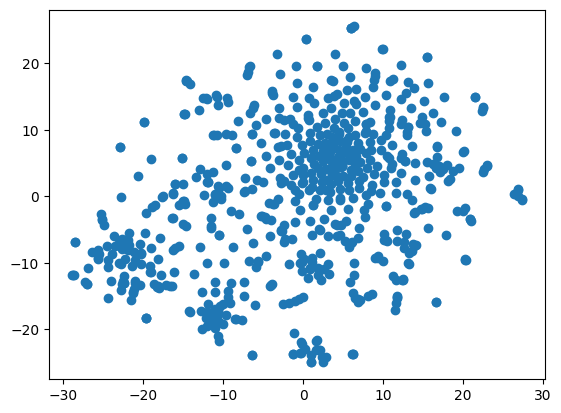

In [238]:
import matplotlib.pyplot as plt
from ge.classify import read_node_label, Classifier
from sklearn.manifold import TSNE
import numpy as np
def plot_embeddings(embeddings:dict[str],):
    # X, Y = read_node_label('./data/followers_over_20000.csv')
    def fun():
        return embeddings.keys(),[[1]for i in range(len(embeddings.keys()))]
    X,Y=fun()
    # print(X,sep='\n')
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    # print(color_idx.items())
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    # plt.legend()
    plt.show()

plot_embeddings(embeddings=embeddings)